In [1]:
import torch, shap, glob, os
import numpy as np, pandas as pd, torchvision.transforms as transforms
import random

from Bio import SeqIO
from tqdm.notebook import tqdm
from torch.nn import Module
from torch import nn
from torch.utils.data import Dataset, DataLoader, Subset
from PIL import Image
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from torchvision.models import  resnet18, alexnet

np.random.seed(2020)
random.seed(2020)
torch.manual_seed(2020)

In [2]:
npy_path = './np_image_totalunit/tsne-binary-perplexity=5-pixel=400[onehot]/'
# npy_path = './np_image_totalunit/multiclass_totalunit/'

save_weight_path ='./models/weights_res18_tsne-binary-perplexity=5-pixel=400[onehot]/'
# save_weight_path = './models/weights_Multiclass_Covid19(Non-kmer3)_IndexRemark.2022.03.24[NACGTRYKMSWBDHV]/'

weights_name = "weights_binaryclass_Covid19(Non-kmer3)[NACGT].2022.05.09-onehot.pt"
# weights_name = "weights_Multiclass_Covid19(Non-kmer3)[NACGTRYKMSWBDHV].2022.03.24.pt"

path2weights = os.path.join(save_weight_path,weights_name)

In [3]:
npy_data_list = [os.path.join(npy_path,'image_npy',i ) for i in sorted(os.listdir(os.path.join(npy_path,'image_npy')))]
label_ = np.load(os.path.join(npy_path,'label.npy'))

In [4]:
nas_path = "./dataset_1401/"
lineage_label = pd.read_csv('./dataset_1401/1404_lineage_report and metadata 20220316.csv')[['scorpio_call_y','diff']]
lineage_label = np.array(lineage_label.fillna("None"))
label_s = []
name_ = []
new_lineage_label = []
for idx, rna in enumerate(SeqIO.parse('./dataset_1401/1404.sequences.aln.fasta',"fasta")):
    if "B.1.617.2" == lineage_label[idx][0]:
    # print(lineage_label[idx][0].split(' ')[0])
        label_s.append(lineage_label[idx][1].split(' ')[0])
        name_.append(lineage_label[idx][0])
        new_lineage_label.append(str(rna.seq))

In [5]:
class_,_ ,_,_= np.unique(label_s,return_counts=True,return_index=True,return_inverse=True)
print(class_)

[]


In [6]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(npy_data_list, label_,stratify = label_, test_size=0.25, random_state=42)

print(len(X_train), len(y_train)) 

print(len(X_test), len(y_test))

851 851
284 284


In [7]:
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms
import glob
from PIL import Image
import torch
import numpy as np
import random
np.random.seed(2020)
random.seed(2020)
torch.manual_seed(2020)

class TransferDataset(Dataset):
    def __init__(self, s_path, labels, transform):
        self.transform = transform
        self.s_path = s_path
        self.labels = labels
        
    def __len__(self):
        return len(self.s_path)

    def __getitem__(self, idx):
        singel_image_ = np.load(self.s_path[idx]).astype(np.float32)
        seed = np.random.randint(1e9)       
        random.seed(seed)
        np.random.seed(seed)
        singel_image_ = self.transform(singel_image_)
        label = float(self.labels[idx])
        # print(label)

        return singel_image_, label

In [8]:
transformer = transforms.Compose([
            transforms.ToTensor(),
            # transforms.Normalize(mean, std),
            ])     

train_ds = TransferDataset(s_path= X_train, labels= y_train, transform= transformer)
test_ds = TransferDataset(s_path= X_test, labels= y_test, transform= transformer)
print(len(train_ds), len(test_ds))

851 284


In [9]:
imgs, label = train_ds[10]
batch_size = 32
train_dl = DataLoader(train_ds, batch_size= batch_size, 
                        shuffle=True)
test_dl = DataLoader(test_ds, batch_size= 2*batch_size, 
                        shuffle=False)  

In [10]:
# eval
def reload_model():
    models = resnet18(pretrained=False, num_classes=1)
    checkpoint = torch.load(path2weights, map_location=torch.device('cpu'))
    # checkpoint = torch.load('./models/weights_Multiclass_Covid19(Non-kmer3)_IndexRemark.2022.03.24[NACGTRYKMSWBDHV]/weights_Multiclass_Covid19(Non-kmer3)[NACGTRYKMSWBDHV].2022.03.24.pt', map_location=torch.device('cpu'))
    models.load_state_dict(checkpoint['model_state_dict'])
    return models

In [11]:
test_dl = DataLoader(test_ds, batch_size= 1, 
                        shuffle=False) 
images, label =next(iter(test_dl))
print(images.shape, label)

torch.Size([1, 3, 440, 440]) tensor([0.], dtype=torch.float64)


In [23]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchcam.methods import SmoothGradCAMpp, LayerCAM, GradCAM
from torchcam.utils import overlay_mask
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class_dict = {0:'N', 1:'Y'}
def loader_cam(image_, lable_, idx): #single classes loader
    model = reload_model().to(device).eval()
    cam_extractor = LayerCAM(model, ["layer2", "layer3", "layer4"])
    classes__ = class_dict[int(lable_)]
    out = model(image_.to(device))
    # print(torch.sigmoid(out))
    cams = cam_extractor(out.squeeze(0).argmax().item(), out)
    fused_cam = cam_extractor.fuse_cams(cams)
    cam_extractor.clear_hooks()
    
    # Resize it
    ths = 0.99
    resized_cams = resize(to_pil_image(fused_cam), img.shape[-2:])
    # resized_cams = [resize(to_pil_image(cam), img.shape[-2:]) for cam in cams]
    segmaps = to_pil_image((resize(fused_cam.unsqueeze(0), img.shape[-2:]).squeeze(0) >= ths).to(dtype=torch.float32))
    # segmaps = [to_pil_image((resize(cam.unsqueeze(0), img.shape[-2:]).squeeze(0) >= ths).to(dtype=torch.float32)) for cam in cams]

    # Calc cam weight
    capture_image = np.where(np.array(segmaps), np.array(images[0][0]), np.array(images[0][0])*0)

    # for name, cam, seg in zip(cam_extractor.target_names, resized_cams, segmaps):
    #     capture_image = np.where(np.array(seg), np.array(images[0][0]), np.array(images[0][0])*0)
    return capture_image, images[0][0].cpu().numpy()
    
save_fig_path = './GramCam_FIG/'
project_name = 'weights_res18_tsne-binary-perplexity=5-pixel=400[onehot]'
if not os.path.exists(os.path.join(save_fig_path)):
    os.mkdir(os.path.join(save_fig_path))
if not os.path.exists(os.path.join(save_fig_path, project_name)):
    os.mkdir(os.path.join(save_fig_path, project_name))

sum_image = np.zeros((440,440))
tsne_image = np.zeros((440,440))
for idx, (img, lab) in enumerate(test_dl):
    if int(lab)==1:
        images = img
        label = lab
        temp, temp2 = loader_cam(images, label, idx)
        tsne_image = tsne_image + temp2
        sum_image = sum_image + temp
        # tsne_image = temp2
        # sum_image = temp
        # break

In [24]:
import pickle as pk, os
save_model_path = './deepinsight_location_npy/'
save_name = 'tsne-binary-perplexity=50-pixel=400[onehot].pkl'
# save_name = 'tsne-binary-perplexity=50-pixel=400.pkl'
it = pk.load(open(os.path.join(save_model_path,save_name),'rb'))

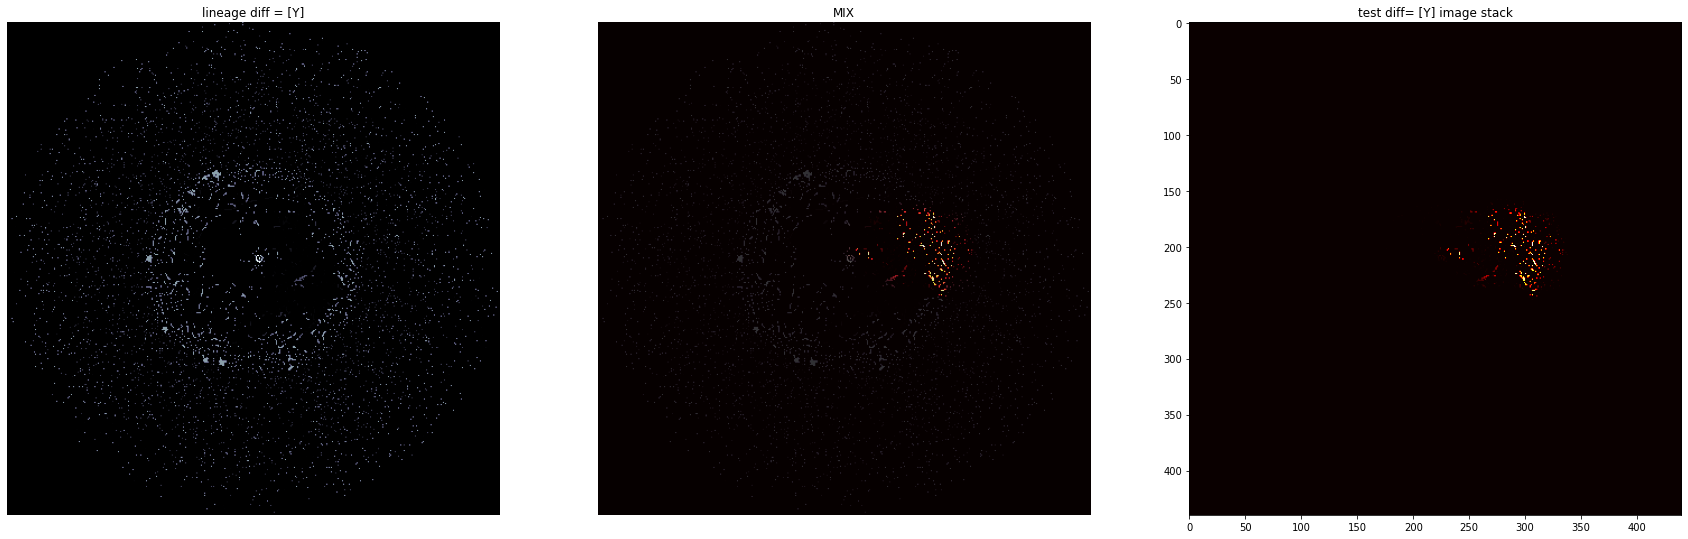

In [25]:
_, axes = plt.subplots(1, 3, figsize=(30, 15))

axes[0].imshow(tsne_image, cmap='bone'); axes[0].axis('off'); axes[0].set_title(f'lineage diff = [Y]')
axes[1].imshow(tsne_image, cmap='bone')
axes[1].imshow(sum_image, alpha=0.7, cmap='hot'); axes[1].axis('off'); axes[1].set_title(f'MIX')
axes[2].imshow(sum_image, cmap='hot'); axes[2].axis('on'); axes[2].set_title(f'test diff= [Y] image stack')

plt.show()

In [26]:
feature_dict = {}
for x, first_array in enumerate(sum_image):
    for y, second_array in enumerate(first_array):
        if second_array>0.0:
            feature_dict[x,y] = second_array
            # print((x,y), round(second_array,8))

In [27]:
RNA_SEQ = {0:'-', 1:'N', 2:'A', 3:'C', 4:'G', 5:'T'}
total_feature_stack = []
for seq_index, xy in enumerate(it.coords()):
    if tuple(xy) in list(feature_dict.keys()):
        total_feature_stack.append([feature_dict[tuple(xy)], seq_index, RNA_SEQ[seq_index%6]])
        # print('index', seq_index, 'rna: ', RNA_SEQ[seq_index%6], 'weight', feature_dict[tuple(xy)])

In [28]:
total_feature_stack = sorted(total_feature_stack, reverse=True)
# total_feature_stack = sorted(total_feature_stack, key = lambda seq_index : seq_index[1])

In [29]:
total_feature_stack

[[70.66413402557373, 149950, 'G'],
 [70.66413402557373, 149926, 'G'],
 [70.66413402557373, 126342, '-'],
 [70.66413402557373, 110316, '-'],
 [70.66413402557373, 72580, 'G'],
 [70.66413402557373, 72412, 'G'],
 [70.66413402557373, 72250, 'G'],
 [70.66413402557373, 64375, 'N'],
 [70.66413402557373, 9878, 'A'],
 [70.03320425748825, 158150, 'A'],
 [70.03320425748825, 153803, 'T'],
 [70.03320425748825, 54053, 'T'],
 [69.47237778455019, 18584, 'A'],
 [69.47237778455019, 18567, 'C'],
 [69.47237778455019, 18546, '-'],
 [69.47237778455019, 18525, 'C'],
 [69.47237778455019, 18519, 'C'],
 [69.47237778455019, 18513, 'C'],
 [69.47237778455019, 18505, 'N'],
 [69.47237778455019, 18493, 'N'],
 [69.47237778455019, 18488, 'A'],
 [69.47237778455019, 18482, 'A'],
 [69.47237778455019, 18475, 'N'],
 [69.47237778455019, 18470, 'A'],
 [69.47237778455019, 18464, 'A'],
 [69.47237778455019, 18457, 'N'],
 [69.47237778455019, 18452, 'A'],
 [69.47237778455019, 18446, 'A'],
 [69.47237778455019, 18439, 'N'],
 [69.4723

In [ ]:
# feature_dict
# {(168, 291): [0.63092977],
#  (168, 296): [0.63092977],
#  (169, 273): [0.63092977],
#  (169, 274): [0.63092977],
#  (170, 286): [0.63092977],
# it.coords()
# array([[ 34, 102],
#        [253,  76],
#        [338,  75],